In [104]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [105]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size = (num_inputs, num_outputs), requires_grad = True)
b = torch.zeros(num_outputs, requires_grad = True)

In [106]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True), X.sum(0), X.sum(1)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]),
 tensor([5., 7., 9.]),
 tensor([ 6., 15.]))

In [107]:
def softmax(x):
    x_exp = torch.exp(x)
    partition = x_exp.sum(1, keepdim = True)
    return x_exp / partition

In [108]:
X = torch.normal(0, 1, (3, 4))
X_softmax = softmax(X)
X_softmax, X_softmax.sum(1, keepdim=True)

(tensor([[0.0759, 0.2140, 0.0832, 0.6268],
         [0.0270, 0.0932, 0.5175, 0.3623],
         [0.1611, 0.4756, 0.2171, 0.1462]]),
 tensor([[1.0000],
         [1.0000],
         [1.0000]]))

In [109]:
def net(X):
    return softmax(torch.matmul(X.reshape(-1, W.shape[0]), W) + b)

In [110]:
y = torch.tensor([0, 1])
y_hat = torch.tensor([[0., 0.5, 0.2], [0., 0.3, 0.4]])
y_hat[[0, 1], y]

tensor([0.0000, 0.3000])

In [111]:
def cross_entropy(y_hat, y):
    #y_hat[range(len(y_hat)), y]
    return - torch.log(y_hat[range(len(y_hat)), y])

torch.log(torch.tensor([2, 1]))

tensor([0.6931, 0.0000])

In [112]:
def accuracy(y_hat, y): # this method return how many elements was predict correctly.
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp_res = y_hat.type(y.dtype) == y
    return float(cmp_res.type(y.dtype).sum()) 

accuracy(y_hat, y) / len(y)

0.0

In [113]:
class Accumulator:  #@save
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [114]:
def evaluate_accuracy(net, data_iter):  #@save
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    # metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    metric = [0, 0]

    with torch.no_grad():
        for X, y in data_iter:
            metric[0] += accuracy(net(X), y)
            metric[1] += y.numel()
            #metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [115]:
#b = torch.tensor(1000000)
evaluate_accuracy(net, test_iter)

0.0939

In [116]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """The training loop defined in Chapter 3."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # Using PyTorch in-built optimizer & loss criterion
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # Using custom built optimizer & loss criterion
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [117]:
class Animator:  #@save
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [118]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """Train a model (defined in Chapter 3)."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [119]:
lr = 0.1

def updater(batch_size):
    #return d2l.sgd([W, b], lr, batch_size)
    for param in [W, b]:
        param = param - param.grad * lr / batch_size

Traceback (most recent call last):
  File "<string>", line 1, in <module>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/kki/anaconda3/envs/d2l/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
  File "/Users/kki/anaconda3/envs/d2l/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/kki/anaconda3/envs/d2l/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
  File "/Users/kki/anaconda3/envs/d2l/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
Traceback (most recent call last):
  File "/Users/kki/anaconda3/envs/d2l/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
  File "<string>", line 1, in <module>
  File "/Users/kki/anaconda3/envs/d2l/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    self = r

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/kki/anaconda3/envs/d2l/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/k2/fn43rcxn73b5tt20b76dfs2c0000gn/T/ipykernel_10554/1400044744.py", line 2, in <module>
    train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)
  File "/var/folders/k2/fn43rcxn73b5tt20b76dfs2c0000gn/T/ipykernel_10554/481548382.py", line 6, in train_ch3
    train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
  File "/var/folders/k2/fn43rcxn73b5tt20b76dfs2c0000gn/T/ipykernel_10554/2077774258.py", line 8, in train_epoch_ch3
    for X, y in train_iter:
  File "/Users/kki/anaconda3/envs/d2l/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 631, in __next__
    data = self._next_data()
  File "/Users/kki/anaconda3/envs/d2l/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1329, in _next_data
    i

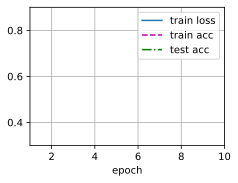

In [120]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

In [ ]:
def predict_ch3(net, test_iter, n=6):  #@save
    """Predict labels (defined in Chapter 3)."""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)